In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/PhD/MatrixProductBP.jl`


In [2]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots

In [3]:
seed = 2
rng = MersenneTwister(seed)

T = 10
N = 5
c = 2.5
# gg = uniform_tree(N; rng)
gg = erdos_renyi(N, c/N; seed)
g = IndexedBiDiGraph(gg)

β = 1.0
h = 0.05
m⁰ = 0.0
K = 30

svd_trunc=TruncBond(10)
;

In [4]:
connected_components(gg)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5]

In [5]:
J = zeros(nv(g),nv(g))
for i in axes(J)[1], j in axes(J)[2]
    j>i && continue
    if has_edge(gg,i,j)
        J[i,j] = 2*rand(rng)-1
        J[j,i] = J[i,j]
    end
end

J

5×5 Matrix{Float64}:
 0.0        0.753632   0.0        0.0        0.310892
 0.753632   0.0        0.0       -0.482892  -0.299763
 0.0        0.0        0.0        0.0       -0.426826
 0.0       -0.482892   0.0        0.0        0.599153
 0.310892  -0.299763  -0.426826   0.599153   0.0

In [6]:
ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

w_fourier = [fill(GlauberFactor([J[ed.src,ed.dst] for ed in inedges(g,i)], h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [7]:
iters, cb_fourier = iterate_fourier!(bp_fourier,K, maxiter=10, σ=1/100; svd_trunc, tol=1e-18);

Running MPBP: iter 2    Time: 0:01:00

Running MPBP: iter 3    Time: 0:01:36

Running MPBP: iter 4    Time: 0:02:12

Running MPBP: iter 5    Time: 0:02:48

Running MPBP: iter 6    Time: 0:03:23

Running MPBP: iter 7    Time: 0:03:57

Running MPBP: iter 8    Time: 0:04:32

Running MPBP: iter 9    Time: 0:05:06

Running MPBP: iter 10    Time: 0:05:40

In [8]:
nsamples = 10^6
sms = SoftMarginSampler(bp_fourier)
sample!(sms, nsamples)
;

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:100


In [9]:
i = 5
m_fourier = real.(means(potts2spin, bp_fourier))[i]

traj = [vec(potts2spin.(X[i,:])) for X in sms.X]
m_mc = mean(traj)
σ_mc = std(traj)./sqrt(nsamples)
;

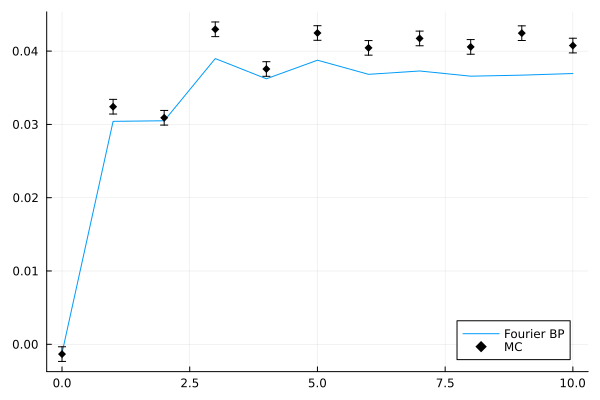

In [10]:
pl = plot(0:T, m_fourier[1:end], label="Fourier BP")
plot!(pl, 0:T, m_mc, yerr=σ_mc, c=:black, m=:diamond, st=:scatter, label="MC")
display(pl)